# Recurrent neural networks (RNNs)

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. LSTMs and CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os
from pathlib import Path

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

No GPU was detected. LSTMs and CNNs can be very slow without a GPU.


# Recurrent Neurons and Layers

* Like a feedforward neural network, except it also has **connections pointing backward**

**A Simple RNN:**

* One neuron receiving **inputs,** producing an **output**, and sending that **output back to itself** 

* At each time step t (also called a frame), this recurrent neuron **receives** the inputs **$x_{(t)}$** as well as its own **output** from the **previous time step, $y_{t-1}$**. At each time step t (also called a frame), this recurrent neuron receives the inputs

* Represent this tiny network against the time axis. This is called **unrolling the network through time**

* In the morning before market open, you want to forecast today's stock price. You read all market news **$x_{(t)}$**, and **you checked the yesterday's predicted price $y_{t-1}$**, then you will have a reasonable prediction for today's price.
* Naively, if you repeat the above step, you can forecast the stock price for the next 10 days.

<p align='center'>
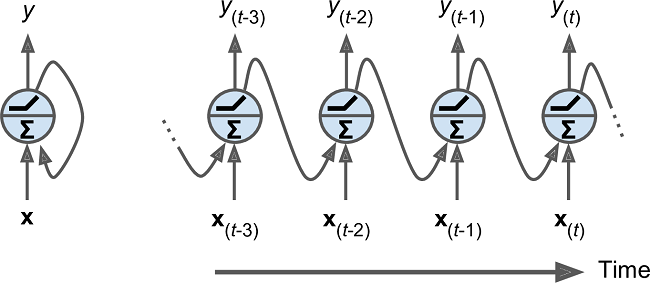
</p>


***Notes:***

* At each time step t, **every neuron receives both the input vector $x_{(t)}$ and the output vector from the previous time step $y_{t-1}$.**

* Both the inputs and outputs are vectors now (when there was just a single neuron, the output was a scalar)

<p align='center'>A layer of recurrent neurons (left) unrolled through time (right)
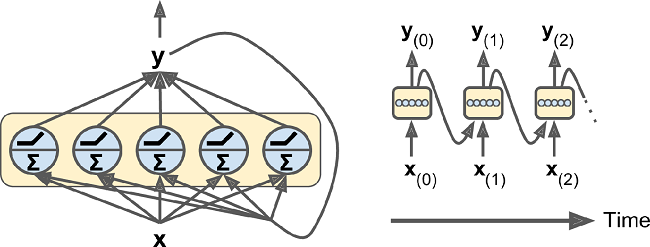
</p>


## The mathematical representation

* **Each recurrent neuron has two sets of weights:** one for the **inputs $x_{(t)}$** and the other for the **outputs of the previous time step, $y_{(t-1)}$**. Let’s call these weight vectors $w_x$ and $w_y$

* If we consider the **whole recurrent layer** instead of just one recurrent neuron, we can place all the **weight vectors in two weight matrices, $W_x$ and $W_y$**


* Output of a recurrent layer for a single instance (b is the bias vector and $Φ(.)$ is the activation function)

$$\Large y_{(t)} = \phi({W_x}^T x_{(t)} + {W_y}^T y_{(t-1)} + b) $$

* Compute a recurrent layer’s output in one shot for a whole **mini-batch** by placing all the inputs at time step t in an input matrix $X_{(t)}$ 

* Outputs of a layer of recurrent neurons for all instances in a mini-batch
<p align='center'>
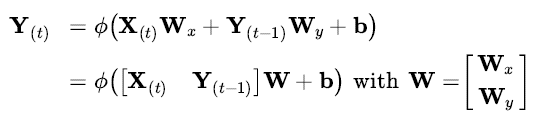
</p>

In this equation:

* $Y_{(t)}$ is an **$m \times n_{\text{neurons}}$ matrix** containing the layer's outputs at time step t for each instance in the **mini-batch** (m is the number of instances in the mini-batch and $n_{\text{neurons}}$ is the number of neurons)

* $X_{(t)}$ is an $m \times n_{\text{inputs}}$ matrix containing the **inputs for all instances** ($n_{\text{inputs}}$ is the number of input features)

* $W_x$ is an $n_{\text{inputs}} \times n_{\text{neurons}}$ matrix containing the **connection weights for the inputs of the current time step**

* $W_y$ is an $n_{\text{neurons}} \times n_{\text{neurons}}$ matrix containing the **connection weights for the outputs of the previous time step**

* $b$ is a vector of size $n_{\text{neurons}}$ containing **each neuron's bias term**

* The weight matrices **$W_x$ and $W_y$** are often concatenated vertically into a **single weight matrix W** of shape $(n_{\text{inputs}} + n_{\text{neurons}}) \times n_{\text{neurons}}$

* The notation $[X_{(t)} Y_{(t-1)}]$ represents the horizontal concatenation of the matrices 

***Recursively, $Y_{(t)}$ a function of all the inputs since time t = 0 (that is, $X_{(0)}, X_{(1)}, \dots, X_{(t)}$), because***

* $Y_{(t)}$ is a function of $X_{(t)}$ and $Y_{(t-1)}$, which is a function of $X_{(t-1)}$ and $Y_{(t-2)}$, which is a function of $X_{(t-2)}$ and $Y_{(t-3)}$, and so on

* At the first time step, t = 0, there are no previous outpus, so they are typically assumed to be all zeros

## Memory Cells

* **Since the output of a recurrent neuron at time step t is a function of all the inputs from previous time steps, you could say it has a form of memory**

* A **part** of a neural network that **preserves some state across time steps** is called a **memory cell** (or simply a cell). 

* A **single recurrent neuron,** or a layer of recurrent neurons, **is a very basic cell,** capable of learning only **short patterns** (typically about 10 steps long)

* In general a cell’s state at time step t, denoted **$h_{(t)}$** (the "h" stands for "hidden"), is a **function of some inputs at that time step and its state at the previous time step:** $h_{(t)} = f(h_{(t-1)}, x_{(t)})$

### A cell’s hidden state and its output may be different

Its output at time step t, denoted $y_{(t)}$, is a function of the previous state and the current inputs. 
* In the case of the basic cells, the output is simply equal to the state
* In more complex cells the hidden state and its output may be different

<p align='center'>
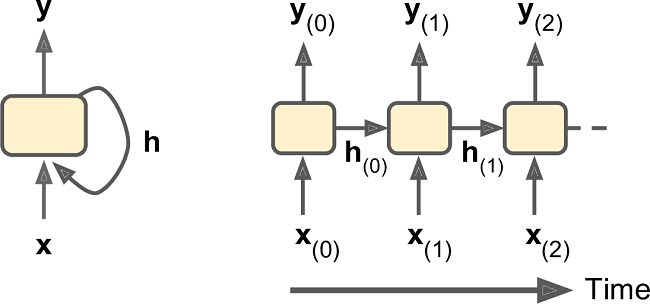
</p>


## Input and Output Sequences: Four Types

1. **sequence-to-sequence network**
    * **simultaneously take a sequence of inputs and produce a sequence of outputs** 

    * This type of **sequence-to-sequence network** is useful for **predicting time series** such as stock prices
    * You feed it the prices over the last N days, and it must output the prices shifted by one day into the future (i.e., from N – 1 days ago to tomorrow)
    
 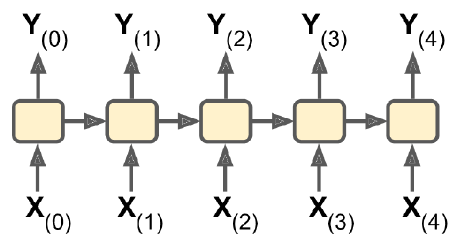

2. **sequence-to-vector network**
    * **Ignore all outputs except for the last one** 

    * For example, you could feed the network a sequence of words corresponding to a movie review, and the network would output a sentiment score (e.g., from –1 [hate] to +1 [love])
    
    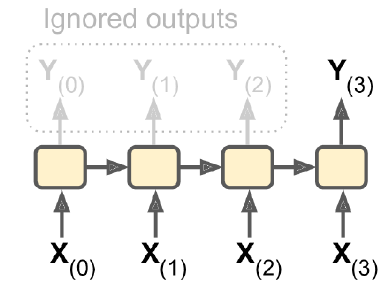
    
    
3. **vector-to-sequence network**

    * **feed the network the same input vector over and over again at each time step** and let it **output a sequence** 
    * This is a **vector-to-sequence network**. 
    * For example, the input could be an image (or the output of a CNN), and the output could be a caption for that image
    
    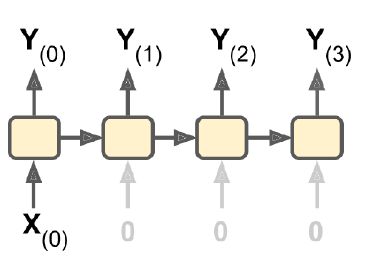


4. **Encoder–Decoder network**

    * A **sequence-to-vector network, called an encoder, followed by** a **vector-to-sequence network, called a decoder** 

    * For example, this could be used for translating a sentence from one language to another. 
    
    * You would feed the network a sentence in one language, the encoder would convert this sentence into a single vector representation, and then the decoder would decode this vector into a sentence in another language


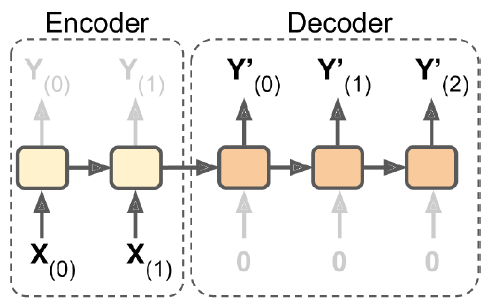

***Notes***

* This two-step model, called an **Encoder–Decoder,** works much better than trying to translate **on the fly** with a single sequence-to-sequence RNN (like the one represented at the top left)
* Because the last words of a sentence can affect the first words of the translation, **so you need to wait until you have seen the whole sentence before translating it**

# Training RNNs

* **backpropagation through time (BPTT)**

    * **unroll it through time** 
    * then simply use **regular backpropagation** 
    
    

<p align='center'>
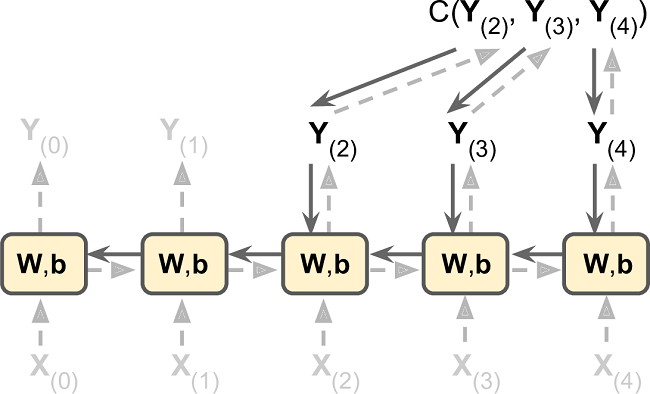
</p>


***Steps:***

* First forward pass through the unrolled network (represented by the dashed arrows). 
* Then the output sequence is evaluated using a cost function $C(Y_{(0)}, Y_{(1)}, \dots Y_{(T)})$ where T is the max time step
* This cost function may ignore some outputs, as shown above (for example, in a sequence-to-vector RNN, all outputs are ignored except for the very last one). 
* The gradients of that cost function are then propagated backward through the unrolled network (represented by the solid arrows)

* Finally the model parameters are updated using the gradients computed during BPTT. 
* Note that the **gradients flow backward through all the outputs used by the cost function,** not just through the final output

* In this example, the cost function is computed using the last three outputs of the network, $Y_{(2)}, Y_{(3)}, \text{and } Y_{(4)}$, so gradients flow through these three outputs, but not through $Y_{(0)} \text{and } Y_{(1)}$

* Moreover, since the same parameters $W$ and $b$ are used at each time step, backpropgation will do the right thing and sum over all time steps

# Forecasting a Time Series

* **Time Series:** one or more values per time step

    * In stock price forecasting there is a **single value per time step,** so these are **univariate time series,** 
    * If there are **multiple values per time step** (e.g., the company’s revenue, debt, and so on), it is a **multivariate time series**
    
    
* **Typical tasks:**

    * **forecasting:** predict future values
    * **imputation:** fill in the blanks: to predict (or rather “postdict”) missing values from the past. 
    
    
* **A simple example of time series forecasting:**

    * 3 univariate time series, each of them 50 time steps long

    * The goal here is to forecast the value at the next time step (represented by the X) for each of them

<p align='center'>
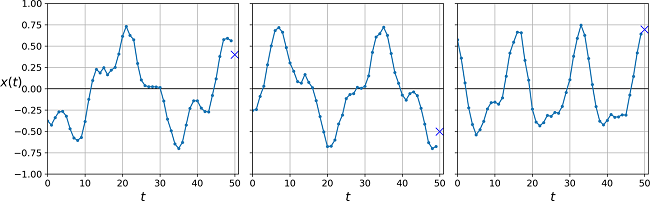
</p>


* Generate dummy time series

In [2]:
import numpy as np
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise
    return series[..., np.newaxis].astype(np.float32)

**Notes**

* This function creates as many time series as requested (via the batch_size argument), each of length n_steps, and there is just one value per time step in each series (all series are univariate)

* The function returns a NumPy array of shape [batch size, time steps, 1], where each series is the sum of two sine waves of fixed amplitudes but random frequencies and phases, plus a bit of noise

* When dealing with time series (and other types of sequences such as sentences), the input features are generally represented as 3D arrays of shape **[batch size, time steps, dimensionality],** where dimensionality is 1 for univariate time series and more for multivariate time series.

Now create a training set, a validation set, and a test set using this function:

In [3]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]
X_train.shape, y_train.shape

((7000, 50, 1), (7000, 1))

In [4]:
X_train

array([[[ 0.4596948 ],
        [ 0.31486678],
        [ 0.12497123],
        ...,
        [ 0.32104868],
        [ 0.13293117],
        [-0.15862931]],

       [[ 0.24511378],
        [ 0.23174433],
        [-0.00599396],
        ...,
        [ 0.49712527],
        [ 0.41383964],
        [ 0.2979726 ]],

       [[ 0.2817575 ],
        [ 0.36084807],
        [ 0.39095697],
        ...,
        [-0.47353426],
        [-0.51123077],
        [-0.47599974]],

       ...,

       [[ 0.4643898 ],
        [ 0.17030203],
        [-0.0747556 ],
        ...,
        [ 0.65820885],
        [ 0.54846185],
        [ 0.3173613 ]],

       [[ 0.0072364 ],
        [-0.20781188],
        [-0.3780026 ],
        ...,
        [-0.07166255],
        [-0.20090096],
        [-0.3475542 ]],

       [[-0.6709723 ],
        [-0.6589038 ],
        [-0.64380425],
        ...,
        [ 0.46026787],
        [ 0.6671777 ],
        [ 0.6631884 ]]], dtype=float32)

In [5]:
y_train

array([[-0.35489398],
       [ 0.11629631],
       [-0.35395944],
       ...,
       [ 0.04946356],
       [-0.26231018],
       [ 0.60062087]], dtype=float32)

* X_train contains 7,000 time series (i.e., its shape is [7000, 50, 1]), while X_valid contains 2,000 (from the 7,000th time series to the 8,999th) and X_test contains 1,000 (from the 9,000th to the 9,999th)

* Since we want to forecast a single value for each series, the targets are column vectors (e.g., y_train has a shape of [7000, 1])

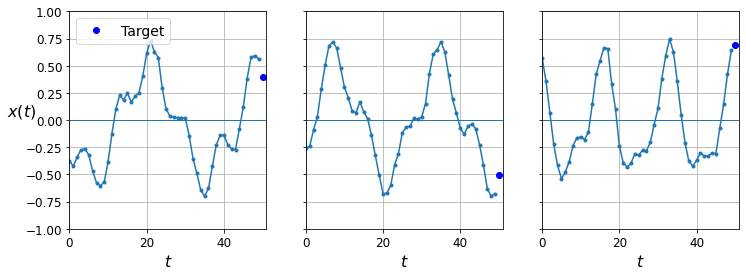

In [6]:
import matplotlib.pyplot as plt
import matplotlib as mpl
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

## Baseline Metrics

**Naive forecasting:** predict the last value in each series

* It is sometimes surprisingly difficult to outperform. 
* In this case, it gives us a mean squared error of about 0.020

In [7]:
import tensorflow as tf
from tensorflow import keras

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

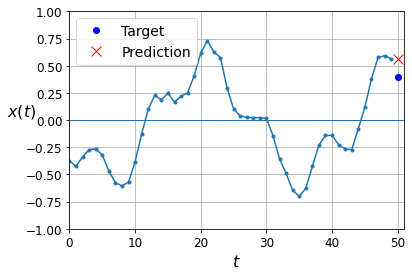

In [8]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

**Fully connected network:** 

* Since it **expects a flat list of features for each input,** we need to add a **Flatten layer.** 
* Let’s just use a simple Linear Regression model so that each prediction will be a linear combination of the values in the time series:

In [9]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 3ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 2ms/step - loss: 0.0061 - val_loss: 0.0062

In [10]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0042


0.004168087150901556

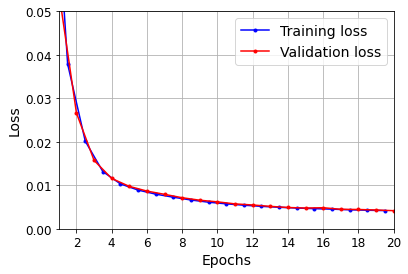

In [11]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])

## Implementing a Simple RNN: a single layer, with a single neuron

In [12]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) 
    # returns the last output. default: use_bias=True, return_sequences=False
])

optimizer = keras.optimizers.Adam(learning_rate=0.005) # adam : default lr=0.001
model.compile(loss='mse', optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0313 - val_loss: 0.0127
Epoch 2/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0119 - val_loss: 0.0112
Epoch 3/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0115 - val_loss: 0.0110
Epoch 4/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 5/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 6/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 7/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 8/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 9/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_loss: 0.0109
Epoch 10/20
219/219 [==============================] - 2s 11ms/step - loss: 0.0114 - val_lo

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 5ms/step - loss: 0.0109


0.01090716291218996

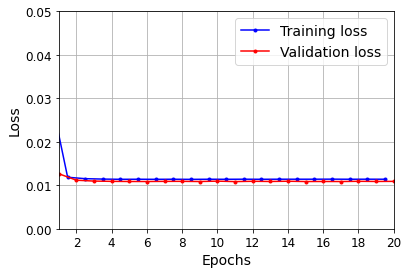

In [14]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

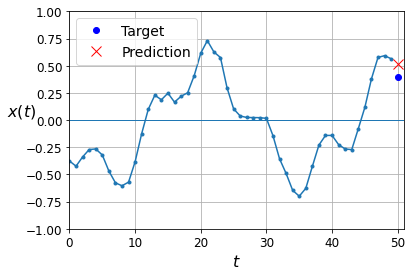

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

> By default, recurrent layers in Keras only return the final output. To make them return one output per time step, you must set return_sequences=True, as we will see.

***Notes:***

* We **do not need to specify the length of the input sequences** (unlike in the previous model), since a **recurrent neural network can process any number of time steps** (this is why we set the first input dimension to None)

* By default, the **SimpleRNN layer** uses the **hyperbolic tangent activation function.** It works exactly as we saw earlier: the initial state $h_{(\text{init})}$ is set to 0, and it is passed to a single recurrent neuron, along with the value of the first time step, $x_{(0)}$

* The neuron computes a weighted sum of these values and applies the hyperbolic tangent activation function to the result, and this gives the first output, $y_0$. **In a simple RNN, this output is also the new state $h_0$**

* This **new state** is passed to the same recurrent neuron **along with the next input value, $x_{(1)}$,** and the process is repeated until the last time step. Then the layer just outputs the last value, $y_{(49)}$. All of this is performed simultaneously for every time series


***Some thoughts about the simple RNN:***

* It is better than the naive approach but it does not beat a simple linear model

* For each neuron, **a linear model has one parameter per input and per time step, plus a bias term** (in the simple linear model we used, that’s a total of **51 parameters**). 
* In contrast, for each recurrent neuron in a simple RNN, there is just one parameter per input and per hidden state dimension (in a **simple RNN,** that’s just the number of recurrent neurons in the layer), plus a bias term. In this simple RNN, that’s a total of just **three parameters**

## Deep RNNs

***The idea:*** Stack multiple layers of cells

<p align='center'>
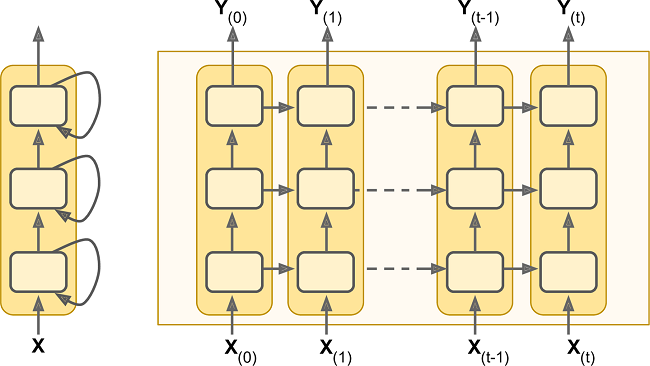
</p>


***Implementation:***

* Stack recurrent layers. 
* In this example, we use three SimpleRNN layers

In [16]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 10s 31ms/step - loss: 0.0175 - val_loss: 0.0051
Epoch 2/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0042 - val_loss: 0.0034
Epoch 3/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 5/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0031 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 7s 30ms/step - loss: 0.0029 - val_loss: 0.0031
Epoch 8/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 10/20
219/219 [==============================] - 6s 29ms/step - loss: 0.0028 - val_l

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 10ms/step - loss: 0.0026


0.0026385639794170856

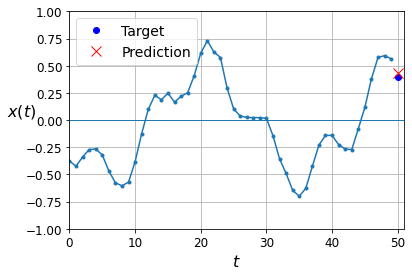

In [18]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

***Notes:***

* The **last layer is not ideal:** it must have a **single unit** because we want to forecast a **univariate time series,** and this means we must have a **single output value per time step**

* However, having a single unit means that the hidden state is just a single number. That’s really not much, and it’s probably not that useful; presumably, the RNN will mostly use the hidden states of the other recurrent layers to carry over all the information it needs from time step to time step, and it will not use the final layer’ hidden state very much

* Moreover, since a SimpleRNN layer uses the tanh activation function by default, the predicted values must lie within the range –1 to 1. But what if you want to use **another activation function?** For both these reasons, it might be preferable to **replace the output layer** with a **Dense layer:** it would run slightly **faster,** the **accuracy** would be roughly the **same,** and it would allow us to **choose** any output **activation function** we want

If you make this change, also make sure to remove return_sequences=True from the second (now last) recurrent layer:


In [19]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20), # remove return_sequences=True
    keras.layers.Dense(1)       # replace the output layer with a Dense layer                        
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.0869 - val_loss: 0.0084
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0059 - val_loss: 0.0045
Epoch 3/20
219/219 [==============================] - 5s 24ms/step - loss: 0.0041 - val_loss: 0.0036
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 5s 25ms/step - loss: 0.0032 - val_loss: 0.0030
Epoch 6/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0029 - val_loss: 0.0029
Epoch 8/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0029 - val_loss: 0.0027
Epoch 9/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0029 - val_loss: 0.0026
Epoch 10/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0028 - val_lo

In [20]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 1s 8ms/step - loss: 0.0027


0.0026609303895384073

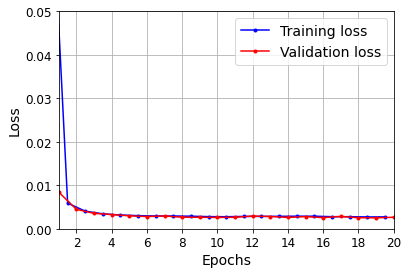

In [21]:
plot_learning_curves(history.history['loss'], history.history['val_loss'])

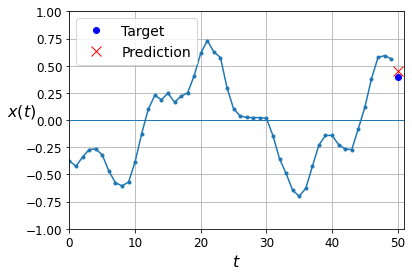

In [22]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])

* Now it **converges faster and performs just as well.** 
* Plus, you could change the output activation function if you wanted

## Forecasting Several Time Steps Ahead: 

* such as next 10 days weather forecasting
* or next 5 days stock price prediction

* **Option 1:** 

    * use the model we already trained, make it predict the next value, then **add that value to the inputs** (acting as if this predicted value had actually occurred), and use the model again to predict the following value, and so on,
    * i.e., forecasting 10 steps ahead, 1 step at a time


as in the following code:

In [23]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

In [24]:
Y_pred.shape

(1, 10, 1)

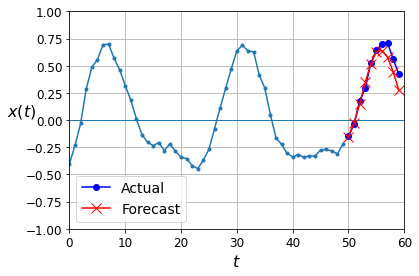

In [25]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)

* **Option 2:** **train an RNN to predict all 10 next values at once.** 

    * We can still use a **sequence-to-vector model**, but it will output 10 values instead of 1. 
    * However, we first need to **change the targets to be vectors containing the next 10 values:**

In [26]:
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

* Now we just need the output layer to have 10 units instead of 1:

In [27]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])

model.compile(loss='mse', optimizer='adam')
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.0581 - val_loss: 0.0262
Epoch 2/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0195 - val_loss: 0.0169
Epoch 3/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0148 - val_loss: 0.0155
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0133 - val_loss: 0.0137
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0122 - val_loss: 0.0116
Epoch 6/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 7/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0108 - val_loss: 0.0104
Epoch 8/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0105 - val_loss: 0.0099
Epoch 9/20
219/219 [==============================] - 5s 21ms/step - loss: 0.0104 - val_loss: 0.0103
Epoch 10/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0097 - val_lo

* After training this model, you can predict the next 10 values at once very easily:

In [28]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, -10:, :]
Y_pred = model.predict(X_new)[..., np.newaxis]

In [29]:
Y_pred.shape

(1, 10, 1)

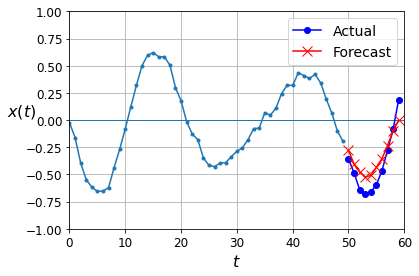

In [30]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

* **Option 3: sequence-to-sequence RNN** 

    * Instead of training the model to forecast the next 10 values only at the very last time step, we can train it to **forecast the next 10 values at each and every time step** by **sequence-to-sequence RNN.**

    * **The loss will contain a term for the output of the RNN at each and every time step,** not just the output at the last time step

    * This means there will be many **more error gradients flowing through the model,** and they won’t have to flow only through time; 
    
    * They will also **flow from the output of each time step.** This will both **stabilize and speed up training**

    * To be clear, at **time step 0** the model will output a vector containing the **forecasts for time steps 1 to 10,** then at **time step 1** the model will **forecast time steps 2 to 11,** and so on

So each target must be a sequence of the same length as the input sequence, containing a 10-dimensional vector at each step. Let’s prepare these target sequences:

In [31]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [32]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

***How to turn the model into a sequence-to-sequence model?***

* We must set **return_sequences=True** in all recurrent layers (even the last one)

* We must **apply the output Dense layer at every time step**, Keras offers a **TimeDistributed** layer for this very purpose: **it wraps any layer** (e.g., a Dense layer) and **applies it at every time step** of its input sequence

* It does this efficiently, by **reshaping the inputs** so that **each time step is treated as a separate instance** (i.e., it reshapes the inputs **from [batch size, time steps, input dimensions] to [batch x size time steps, input dimensions];** 


***In this example:***

* the **number of input dimensions is 20 because the previous SimpleRNN layer has 20 units),** 
* then it runs the Dense layer, 
* and finally it **reshapes the outputs back to sequences** (i.e., it reshapes the outputs from
[batch size × time steps, output dimensions] to [batch size, time steps, output dimensions];

In this example the number of **output dimensions is 10,** since the **layer has 10 units).** Here is the updated model: Dense


In [33]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

**The Dense layer actually supports sequences as inputs** (and even higher dimensional inputs): **it handles them just like TimeDistributed(Dense(...)),** meaning it is applied to the last input dimension only (independently across all time steps). **Thus, we could replace the last layer with just Dense(10)**

For the sake of clarity, however, we will keep using TimeDistributed(Dense(10) because it makes it clear that the **Dense layer is applied independently at each time step and that the model will output a sequence, not just a single vector**

All outputs are needed during training, but **only the output at the last time step is useful for predictions and for evaluation.** So although we will rely on the MSE over all the outputs for training, we will use a custom metric for evaluation, to **only compute the MSE over the output at the last time step:**

In [34]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 7s 22ms/step - loss: 0.0519 - last_time_step_mse: 0.0417 - val_loss: 0.0428 - val_last_time_step_mse: 0.0304
Epoch 2/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0370 - last_time_step_mse: 0.0242 - val_loss: 0.0348 - val_last_time_step_mse: 0.0218
Epoch 3/20
219/219 [==============================] - 4s 21ms/step - loss: 0.0325 - last_time_step_mse: 0.0194 - val_loss: 0.0299 - val_last_time_step_mse: 0.0173
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0290 - last_time_step_mse: 0.0160 - val_loss: 0.0269 - val_last_time_step_mse: 0.0145
Epoch 5/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0280 - last_time_step_mse: 0.0165 - val_loss: 0.0253 - val_last_time_step_mse: 0.0141
Epoch 6/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0258 - last_time_step_mse: 0.0144 - val_loss: 0.0248 - val_last_time_step_mse: 0.0146
Epoch 7/20
219/219 [==

In [35]:
series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

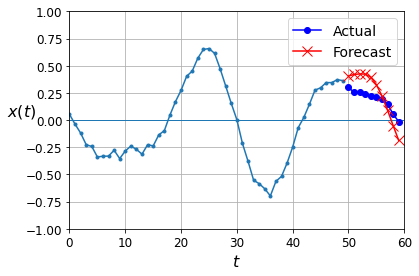

In [36]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)

We get a validation MSE of about 0.006, which is 25% better than the previous model

***How to forecast more time steps:***

   * Combine this approach with the first one: just predict the next 10 values using this RNN, 
   * then concatenate these values to the input time series and use the model again to predict the next 10 values, 
   * and repeat the process as many times as needed

# Handling Long Sequences

### Two Challenges:

* To train an RNN on long sequences, we must run it over many time steps, making the unrolled RNN a very deep network

* Just like any deep neural network it may suffer from the **unstable gradients problem,** it may take forever to train, or training may be unstable

* Moreover, **when an RNN processes a long sequence, it will gradually forget the first inputs** in the sequence

## Fighting the Unstable Gradients Problem

**The techniques that we have learned so far:** 

   * good parameter initialization
   * faster optimizers
   * dropout
   * and so on
   * However, most of the techniques don't work well for deep RNN for various reasons.


**New technique: Layer Normalization**: 

   * it is very similar to Batch Normalization, but instead of normalizing across the batch dimension**, it normalizes across the features dimension**

   * **compute the required statistics on the fly, at each time step, independently for each instance.** 
   * This also means that it **behaves the same way during training and testing** (as opposed to BN), and it does not need to use exponential moving averages to estimate the feature statistics across all instances in the training set. 
   * Like BN, Layer Normalization learns a scale and an offset parameter for each input. 
   * **In an RNN, it is typically used right after the linear combination of the inputs and the hidden states**

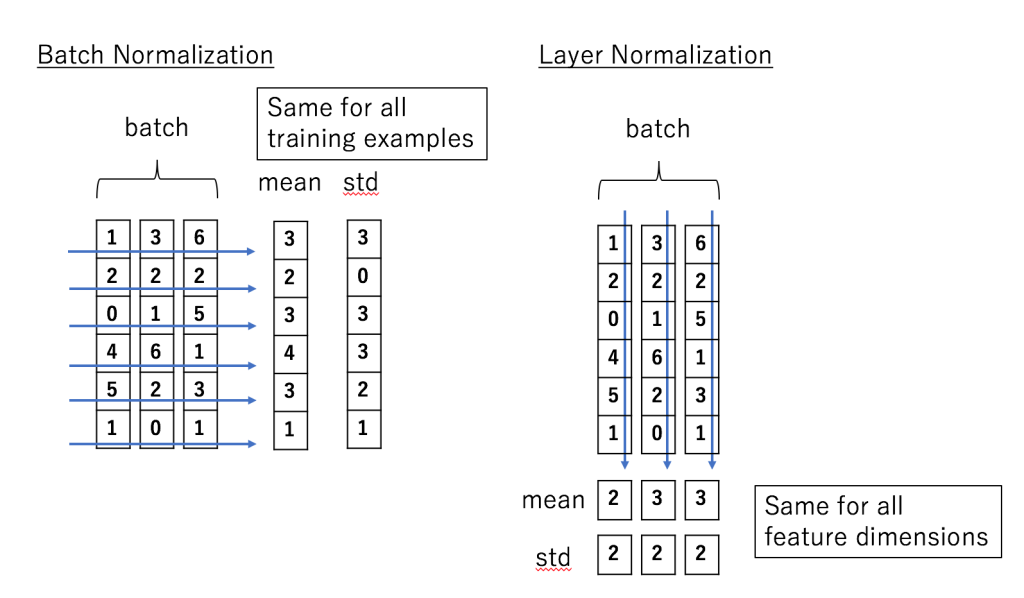

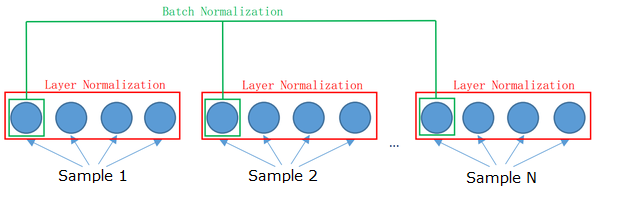

**The implementation:**

   * Use tf.keras to implement Layer Normalization within a simple memory cell. 
   * For this, we need to define a custom memory cell. 
   * It is just like a regular layer, except its call() method takes two arguments: the inputs at the current time step and the hidden states from the previous time step


**Notes:**

   * The **states argument** is a **list containing one or more tensors.** 
   * In the case of a **simple RNN cell** it **contains a single tensor equal to the outputs of the previous time step,** 
   * But other cells may have multiple state tensors (e.g., an LSTMCell has a long-term state and a short term state)
   * A cell must also have a **state_size attribute** and an **output_size attribute.** 
   * In a simple RNN, both are simply equal to the number of units. 
   
The following code implements a custom memory cell which will behave like a SimpleRNNCell, except it will also apply Layer Normalization at each time step:

In [37]:
from tensorflow.keras.layers import LayerNormalization

In [38]:
# LNSimpleRNNCell class inherits from the keras.layers.Layer class, just like any custom layer
class LNSimpleRNNCell(keras.layers.Layer):
    
    # The constructor takes the number of units and the desired activation function
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units 
        # set the state_size and output_size attributes
        
        self.output_size = units
        
        # creates a SimpleRNNCell with no activation function 
        # (because we want to perform Layer Normalization after the linear operation but before the activation function)
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization() 
        # creates the LayerNormalization layer
        
        self.activation = keras.activations.get(activation) 
        # finally it fetches the desired activation function
        
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states) 
        #starts by applying the simple RNN cell, which computes a linear combination of the current inputs and the previous hidden states
        # it returns the result twice (indeed, in a SimpleRNNCell, 
        # the outputs are just equal to the hidden states: in other words, new_states[0] us equal to outpus, 
        # so we can safely ignore new_states in the rest of the call() method)
        
        norm_outputs = self.activation(self.layer_norm(outputs)) 
        # applies Layer Normalization, followed by the activation function
        
        return norm_outputs, [norm_outputs] 
        # it returns the outputs twice (one as the outputs, and one as the new hidden states)

* To use this custom cell, all we need to do is create a keras.layers.RNN layer, passing it a cell instance:

In [39]:
model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                      validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 52ms/step - loss: 0.1368 - last_time_step_mse: 0.1205 - val_loss: 0.0736 - val_last_time_step_mse: 0.0603
Epoch 2/20
219/219 [==============================] - 11s 52ms/step - loss: 0.0628 - last_time_step_mse: 0.0509 - val_loss: 0.0573 - val_last_time_step_mse: 0.0440
Epoch 3/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0529 - last_time_step_mse: 0.0396 - val_loss: 0.0501 - val_last_time_step_mse: 0.0360
Epoch 4/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0476 - last_time_step_mse: 0.0342 - val_loss: 0.0454 - val_last_time_step_mse: 0.0319
Epoch 5/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0433 - last_time_step_mse: 0.0298 - val_loss: 0.0412 - val_last_time_step_mse: 0.0275
Epoch 6/20
219/219 [==============================] - 11s 49ms/step - loss: 0.0389 - last_time_step_mse: 0.0248 - val_loss: 0.0372 - val_last_time_step_mse: 0.0221
Epoch 7/20
219/2

**Don't forget dropout technique**

* Similarly, you could create a custom cell to apply dropout between each time step. But there’s a simpler way: **all recurrent layers** (except for keras.layers.RNN) and all cells provided by Keras have a **dropout hyperparameter** and a **recurrent_dropout hyperparameter:**

* The **former** defines the **dropout rate to apply to the inputs (at each time step),** and the **latter defines the dropout rate for the hidden states** (also at each time step). No need to create a custom cell to apply dropout at each time step in an RNN

* For example, https://keras.io/api/layers/recurrent_layers/simple_rnn/

## Tackling the Short-Term Memory Problem

**Due to the transformations** that the data goes through when traversing an RNN, **some information is lost at each time step.** After a while, the RNN’s state contains virtually no trace of the first inputs

* Various types of cells with long-term memory have been introduced. 

* The most popular of these long-term memory cells: **the LSTM cell**


### The Long Short-Term Memory (LSTM) cell

* If you consider the LSTM cell as a black box, it can be used very much like a basic cell, except it will perform much better; 
* **training will converge faster,** and it **will detect long-term dependencies in the data**

In Keras, you can simply use the LSTM layer instead of the SimpleRNN layer: 

In [40]:
model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 15s 47ms/step - loss: 0.0774 - last_time_step_mse: 0.0638 - val_loss: 0.0543 - val_last_time_step_mse: 0.0342
Epoch 2/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0473 - last_time_step_mse: 0.0259 - val_loss: 0.0418 - val_last_time_step_mse: 0.0220
Epoch 3/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0387 - last_time_step_mse: 0.0173 - val_loss: 0.0363 - val_last_time_step_mse: 0.0160
Epoch 4/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0349 - last_time_step_mse: 0.0149 - val_loss: 0.0335 - val_last_time_step_mse: 0.0143
Epoch 5/20
219/219 [==============================] - 10s 43ms/step - loss: 0.0327 - last_time_step_mse: 0.0139 - val_loss: 0.0315 - val_last_time_step_mse: 0.0133
Epoch 6/20
219/219 [==============================] - 9s 42ms/step - loss: 0.0311 - last_time_step_mse: 0.0131 - val_loss: 0.0306 - val_last_time_step_mse: 0.0134
Epoch 7/20
219/219 [

* Alternatively, you could use the general-purpose keras.layers.RNN layer, giving it an LSTMCell as an argument
* The layer uses an optimized implementation when running LSTM on a **GPU ,** so in general it is preferable to use it (the RNN layer is mostly useful when you define custom cells, as we did earlier)

In [41]:
model = keras.models.Sequential([
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(keras.layers.LSTMCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

### LSTM cell architecture

* The LSTM cell looks exactly like a regular cell, except that its state is split into two vectors: $h_{(t)}$ and $c_{(t)}$ ("c" stands for "cell"). 

* You can think of **$h_{(t)}$** as the **short-term state** and **$c_{(t)}$** as the **long-term state**

<p align='center'>
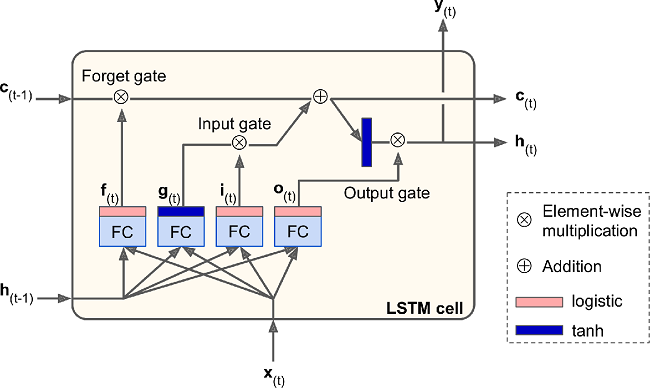
</p>


### The key idea:

* The network **can learn what to store in the long-term state, what to throw away, and what to read from it**

* As the long-term state $c_{t-1}$ traverses the network from left to right, you can see that it first goes through a **forget gate, dropping some memories,** and then it **adds some new memories** via the **addition operation** (which **adds the memories that were selected by an input gate)** The result **$c_{(t)}$ is sent straight out, without any further transformation**

* So, **at each time step, some memories are dropped and some memories are added.** Moreover, **after the addition operation,** the **long-term state is copied and passed through the tanh function, and then the result is filtered by the output gate. This produces the short-term state $h_{(t)}$ (which is equal to the cell’s output for this time step, $y_{t}$**

### Where new memories come from and how the gates work:

First, the current input vector **$x_{(t)}$ and the previous short-term state $h_{(t-1)}$ are fed to four different fully connected layers.** They all server a diffrerent purpose:

* The **main layer** is the one that outputs **$g_{(t)}$**. It has the usual role of **analyzing** the **current inputs $x_{(t)}$** and the **previous (short term) state $h_{(t-1)}$**. In a basic cell, there is nothing other than this layer, and its **output goes straight out to $y_{(t)}$ and $h_{(t)}$** In contrast, in an LSTM cell this layer's output does not go straight out, but instead its **most important parts are stored in the long-term state** (and the rest is dropped)

* The **three other layers are gate controllers.** Since they use the **logistic activation function,** their **outputs range from 0 to 1.** As you can see, their **outputs are fed to element-wise multiplication operations,** so if they output **0s they close the gate,** and if they output **1s they open it.** Specifically:

  * The **forget gate** (controlled by **$f_{(t)}$)** controls **which parts of the long-term state should be erased**

  * The **input gate** (controlled by **$i_{(t)}$)** controls **which parts of $g_{(t)}$ should be added to the long-term state**

  * The **output gate** (controlled by **$o_{(t)}$)** controls **which parts of the long-term state should be read and output at this time step, both to $h_{(t)}$ and to $y_{(t)}$**

**Summary**

LSTM cell can learn to **recognize an important input** (that’ the role of the **input gate)**, **store it in the long-term state,** preserve it for as long as it is needed (that’s the role of the **forget gate)**, and extract it whenever it is needed

This explains why these cells have been amazingly successful at capturing long-term patterns




LSTM computations - how to compute the cell’s long-term state, its short-term state, and its output at each time step for a single instance

<p align='center'>
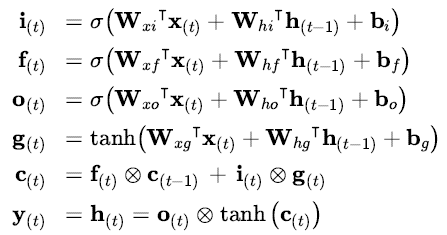
</p>

In this equation:

* $W_{xi}$, $W_{xf}$, $W_{xo}$, $W_{xg}$ are the **weight** matrices of each of the four layers for their connection to the **input vector $x_{(t)}$**

* $W_{hi}$, $W_{hf}$, $W_{ho}$ and $W_{hg}$ are the **weight** matrices of each of the four layers for their connection to the **previous short-term state $h_{(t-1)}$**

* $b_i$, $b_f$, $b_o$, and $b_g$ are the bias terms for each of the four layers. Note that TensorFlow initializes b to a vector full of 1s instead of 0s. This prevents forgetting everything at the beginning of training


### Peephole connections

* **In a regular LSTM cell, the gate controllers can look only at the input $x_{(t)}$ and the previous short-term state $h_{(t-1)}$**

* It may be a good idea to give them a bit more context by letting them peek at the long-term state as well. 

* **LSTM variant with extra connections** called **peephole connections**: 
    * the previous long-term state $c_{(t-1)}$ is added as an input to the controllers of the forget gate and the input gate, 
    * and the current long-term state $c_{(t)}$ is added as input to the controller of the output gate




<p align='center'>
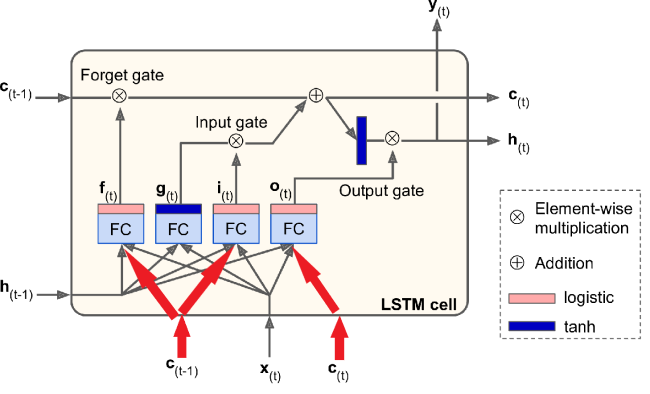
</p>

**Notes**

* This often improves performance, but not always, and there is no clear pattern for which tasks are better off with or without them

* In keras, the LSTM layer is based on the keras.layers.LSTMCell cell, which does not support peepholes. The experimental **tf.keras.experimental.PeepholeLSTMCell** does, however, so you can create a keras.layers.RNN layer and pass a PeepholeLSTMCell to its constructor

* There are many other variants of the LSTM cell. One particularly popular variant is the GRU cell, which we will look at now

### GRU cells

The **Gated Recurrent Unit (GRU)** cell that also introduced the Encoder-Decoder network we discuessed earlier

<p align='center'>
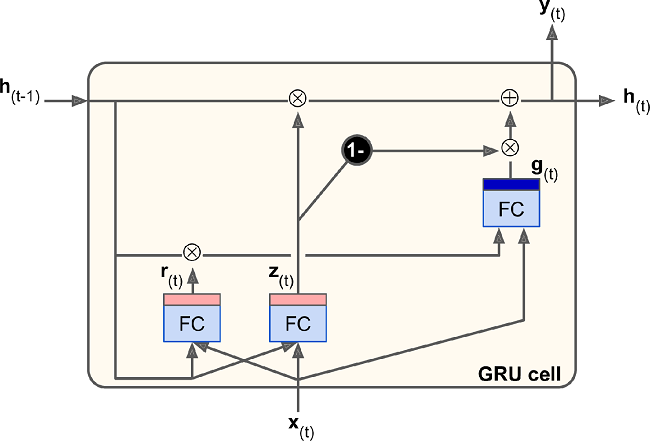
</p>

The GRU cell is a **simplified version** of the **LSTM cell,** and it seems to **perform just as well** (which explains its growing popularity)

These are the main simplifications: 

* Both state vectors are merged into a single vector $h_{(t)}$

* A single gate controller **$z_{(t)}$ controls both the forget gate and the input gate.** **If the gate controller outputs a 1, the forget gate is open (= 1) and the input gate is closed (1 – 1 = 0).** If it outputs a 0, the opposite happens. In other words, **whenever a memory must be stored, the location where it will be stored is erased first.** This is actually a frequent variant to the LSTM cell in and of itself

* There is **no output gate;** the **full state vector is output at every time step.** However, there is a **new gate controller $r_{(t)}$ that controls which part of the previous state will be shown to the main layer ($g_{(t)}$)**


GRU computations -- how to compute the cell’s state at each time step for a single instance
<p align='center'>
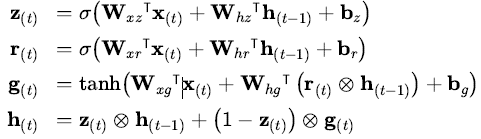
</p>

**Notes**

* Keras provides a **keras.layers.GRU** layer (based on the keras.layers.GRUCell memory cell); using it is just a matter of replacing SimpleRNN or LSTM with GRU

* **LSTM and GRU** cells are one of the main reasons behind the success of RNNs. Yet while they can tackle much longer sequences than simple RNNs, they **still have a fairly limited short-term memory, and they have a hard time learning long-term patterns in sequences of 100 time steps or more,** such as audio samples, long time series, or long sentences

One way to solve this is to **shorten the input sequences,** for example **using 1D convolutional layers**

### Using 1D convolutional layers to process sequences

2D convolutional layer works by sliding several fairly small kernels (or filters) across an image, producing multiple 2D feature maps (one per kernel)

Similarly, a **1D convolutional layer slides several kernels across a sequence, producing a 1D feature map per kernel. Each kernel will learn to detect a single very short sequential pattern** (no longer than the kernel size). If you use 10 kernels, then the layer’s output will be composed of 10 1-dimensional sequences (all of the same length), or equivalently you can view this output as a single 10- dimensional sequence. This means that you can build a neural network composed of a mix of recurrent layers and 1D convolutional layers (or even 1D pooling layers) 

If you use a 1D convolutional layer with a stride of 1 and "same" padding, then the output sequence will have the same length as the input sequence. But if you use "valid" padding or a stride greater than 1, then the output sequence will be shorter than the input sequence, so make sure you adjust the targets accordingly

For example, the following model is the same as earlier, except it **starts with a 1D convolutional layer that downsamples** the input sequence by a **factor of 2,** using a stride of 2. The kernel size is larger than the stride, so all inputs will be used to compute the layer’s output, and therefore the model can learn to **preserve the useful information, dropping only the unimportant details.** By shortening the sequences, the convolutional layer may help the GRU layers detect longer patterns 

Note that we must also crop off the first three time steps in the targets (since the kernel’s size is 4, the first output of the convolutional layer will be based on the input time steps 0 to 3), and downsample the targets by a factor of 2:



In [42]:
model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding='valid', 
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

Epoch 1/20
219/219 [==============================] - 12s 30ms/step - loss: 0.0688 - last_time_step_mse: 0.0613 - val_loss: 0.0472 - val_last_time_step_mse: 0.0393
Epoch 2/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0389 - last_time_step_mse: 0.0316 - val_loss: 0.0338 - val_last_time_step_mse: 0.0255
Epoch 3/20
219/219 [==============================] - 6s 27ms/step - loss: 0.0310 - last_time_step_mse: 0.0227 - val_loss: 0.0293 - val_last_time_step_mse: 0.0208
Epoch 4/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0271 - last_time_step_mse: 0.0175 - val_loss: 0.0253 - val_last_time_step_mse: 0.0153
Epoch 5/20
219/219 [==============================] - 6s 26ms/step - loss: 0.0245 - last_time_step_mse: 0.0143 - val_loss: 0.0234 - val_last_time_step_mse: 0.0129
Epoch 6/20
219/219 [==============================] - 6s 28ms/step - loss: 0.0231 - last_time_step_mse: 0.0127 - val_loss: 0.0229 - val_last_time_step_mse: 0.0132
Epoch 7/20
219/219 [=

### WaveNet

**The idea**

* **Stack 1D convolutional layers, doubling the dilation rate** (how spread apart each neuron’s inputs are) at every layer: the first convolutional layer gets a glimpse of just two time steps at a time, while the next one sees four time steps (its receptive field is four time steps long), the next one sees eight time steps, and so on

* the **lower layers learn short-term patterns,** while the **higher layers learn long-term patterns.** Thanks to the doubling dilation rate, the network can process extremely large sequences very efficiently

<p align='center'>
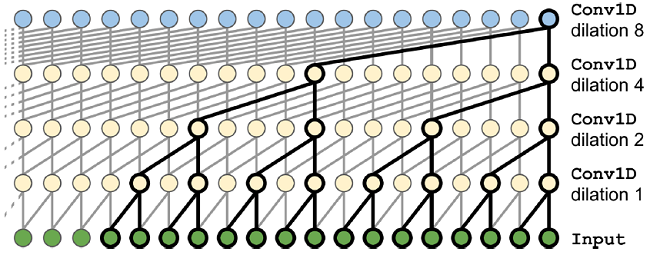
</p>

Here is how to implement a simplified WaveNet to tackle the same sequences as earlier:

In [43]:
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding='causal',
                                activation='relu', dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss='mse', optimizer='adam', metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 5s 17ms/step - loss: 0.0671 - last_time_step_mse: 0.0563 - val_loss: 0.0373 - val_last_time_step_mse: 0.0242
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0327 - last_time_step_mse: 0.0201 - val_loss: 0.0305 - val_last_time_step_mse: 0.0176
Epoch 3/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0285 - last_time_step_mse: 0.0163 - val_loss: 0.0269 - val_last_time_step_mse: 0.0146
Epoch 4/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0264 - last_time_step_mse: 0.0146 - val_loss: 0.0254 - val_last_time_step_mse: 0.0135
Epoch 5/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0248 - last_time_step_mse: 0.0131 - val_loss: 0.0239 - val_last_time_step_mse: 0.0125
Epoch 6/20
219/219 [==============================] - 3s 16ms/step - loss: 0.0239 - last_time_step_mse: 0.0124 - val_loss: 0.0233 - val_last_time_step_mse: 0.0117
Epoch 7/20
219/219 [==

The Sequential model **starts with an explicit input layer** (this is simpler than trying to **set input_shape only on the first layer),** then continues with a 1D convolutional layer using **"casual" padding:** this **ensures that the convolutional layer does not peek into the future when making predictions** (it is equivalent to padding the inputs with the **right amount of zeros on the left and using "valid" padding)**

We then add similar pairs of layers using growing dilation rates: 1, 2, 4, 8, and again 1, 2, 4, 8. Finally, we add the output layer: a convolutional layer with 10 filters of size 1 and without any activation function

Thanks to the padding layers,** every convolutional layer outputs a sequence of the same length as the input sequences,** so the targets we use during training can be the full sequences: no need to crop them or downsample them

The last two models offer the best performance so far in forecasting our time series! In the **WaveNet** paper, the authors achieved state-of-the-art performance on various audio tasks (hence the name of the architecture), including **text-to-speech tasks, producing incredibly realistic voices across several languages.** They also used the model to **generate music,** one audio sample at a time. This feat is all the more impressive when you realize that a single second of audio can contain tens of thousands of time steps— even LSTMs and GRUs cannot handle such long sequences